# Digit Recognizer

The MNIST dataset, consists of a collection of 28x28 grayscale images of handwritten digits (0 through 9). In this notebook, we will create a model using Convolutional Neural Networks (CNN) with tensorflow for the hand written digits classification.

### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt

### Preparing Data

Defining the path of both the training and test data.

In [2]:
training_set = "./dataset/train.csv"
test_set = "./dataset/test.csv"

The train file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each digit) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

In [3]:
with open(training_set) as train:
    print(f"first line of train.csv \n{train.readline()}")
    print(f"second line of train.csv \n{train.readline()}")

first line of train.csv 
label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119

Unlike the training data, the test data doesn't contain a label column.

In [4]:
with open(test_set) as train:
    print(f"first line of test.csv \n{train.readline()}")
    print(f"second line of test.csv \n{train.readline()}")

first line of test.csv 
pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel1

The function below read csv file into numpy array. For the training data, it split labels and all the pixels with a reshape of (28, 28). Since the test data doesn't contain a label column, we only read the pixels and reshaping it by setting the parameter `is_test` to `True`.

In [5]:
def from_csv_nparray(csv_file, is_test=False):
    with open(csv_file) as file:
        reader = np.loadtxt(file, delimiter=',', skiprows=1)
        if is_test:
            images = reader.reshape((-1, 28, 28))
            return images
        labels = reader[:,0]
        images = reader[:, 1:].reshape((-1, 28, 28))

        return labels, images

In [6]:
Y, X = from_csv_nparray(training_set)

print(f"X shape : {X.shape}")
print(f"Y shape : {Y.shape}")

X shape : (42000, 28, 28)
Y shape : (42000,)


Converting digit labels from (0-9) into their one-hot encoded form.

In [7]:
Y_one_hot = to_categorical(Y)
Y_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Splitting the taining data into taining-validation split.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, Y_one_hot, train_size=0.75, random_state=1, shuffle=True)

print(f"X train shape : {X_train.shape}")
print(f"Y train shape : {y_train.shape}")
print(f"X validation shape : {X_val.shape}")
print(f"Y validation shape : {y_val.shape}")

X train shape : (31500, 28, 28)
Y train shape : (31500, 10)
X validation shape : (10500, 28, 28)
Y validation shape : (10500, 10)


### Visualizing Data

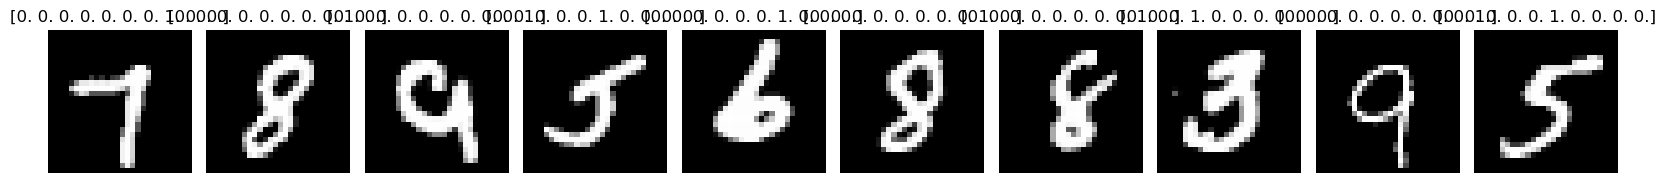

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(16, 15))
axes = axes.flatten()

for i in range(10):
    img = X_train[i]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[i]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{y_train[i]}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### Creating the image data generators

First, we apply [np.expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) to add the "color" dimension to the numpy arrays that encode the images. Since the images are black and white, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images).

We used tensorflow's [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to generate batches of tensor image data with real-time data augmentation. Data augmentation involves applying random transformations to the training images, which can improve the model's generalization.

In [10]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.1,
                                   zoom_range=0.05,
                                   horizontal_flip=False,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x=X_train, y=y_train, batch_size=256)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow(x=X_val, y=y_val, batch_size=256)

### Creating the CNN

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    BatchNormalization(axis=1),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(axis=1),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=1),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    BatchNormalization(),
    Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       112       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       56        
 hNormalization)                                                 
                                                        

### Defining a callback

For our model training, we are including the following callback :
- **ModelCheckpoint** saves the model with the lowest validation loss during training.
- **EarlyStopping** monitors a specific metric (in our case `validation loss`) during training, and it stops training if the monitored metric does not improve according to the specified conditions (in our case `mode='min'`) for a certain number of epochs controlled by the patience parameter `patience=3`.
- **TensorBoard** is a visualization tool logs events for TensorBoard, including:
    - Metrics summary plots
    - Training graph visualization
    - Weight histograms
    - Sampled profiling

In [15]:
checkpoint_path = 'checkpoint/best_model.h5'

_callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=3, mode='min'),
    TensorBoard(log_dir='./logs')
]

### Training the model

In [16]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    callbacks=_callbacks)

Epoch 1/50
124/124 [==============================] - 33s 257ms/step - loss: 3.4840 - accuracy: 0.9318 - val_loss: 2.7645 - val_accuracy: 0.1019
Epoch 2/50
124/124 [==============================] - 32s 258ms/step - loss: 0.4589 - accuracy: 0.9670 - val_loss: 1.3260 - val_accuracy: 0.5665
Epoch 3/50
124/124 [==============================] - 33s 266ms/step - loss: 0.3133 - accuracy: 0.9718 - val_loss: 0.4420 - val_accuracy: 0.9570
Epoch 4/50
124/124 [==============================] - 32s 258ms/step - loss: 0.4002 - accuracy: 0.9725 - val_loss: 0.3873 - val_accuracy: 0.9502
Epoch 5/50
124/124 [==============================] - 32s 257ms/step - loss: 0.3031 - accuracy: 0.9747 - val_loss: 1.4189 - val_accuracy: 0.8258
Epoch 6/50
124/124 [==============================] - 33s 266ms/step - loss: 0.3811 - accuracy: 0.9767 - val_loss: 0.2432 - val_accuracy: 0.9810
Epoch 7/50
124/124 [==============================] - 32s 256ms/step - loss: 0.3304 - accuracy: 0.9788 - val_loss: 0.2333 - val_ac

### Plotting the training history

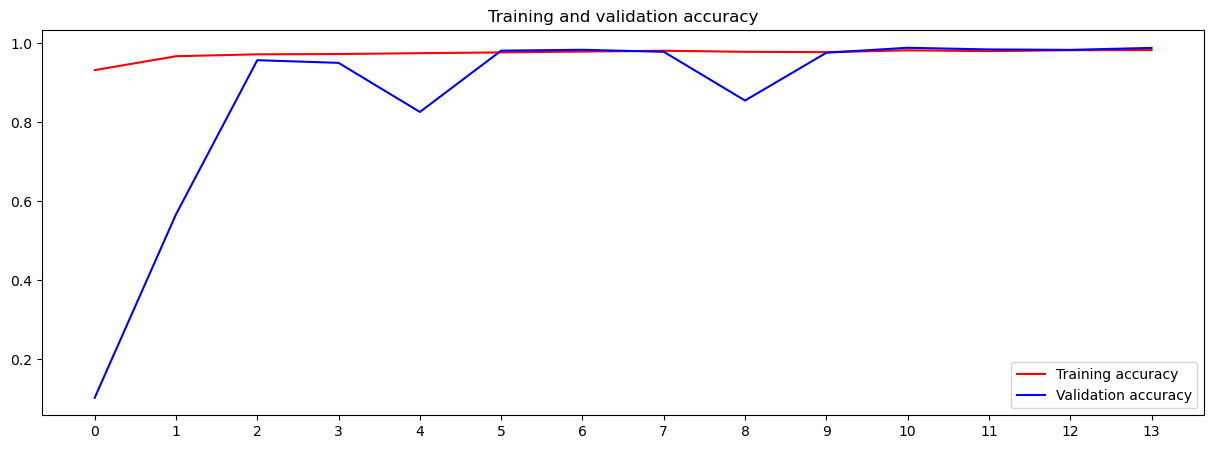

<Figure size 640x480 with 0 Axes>

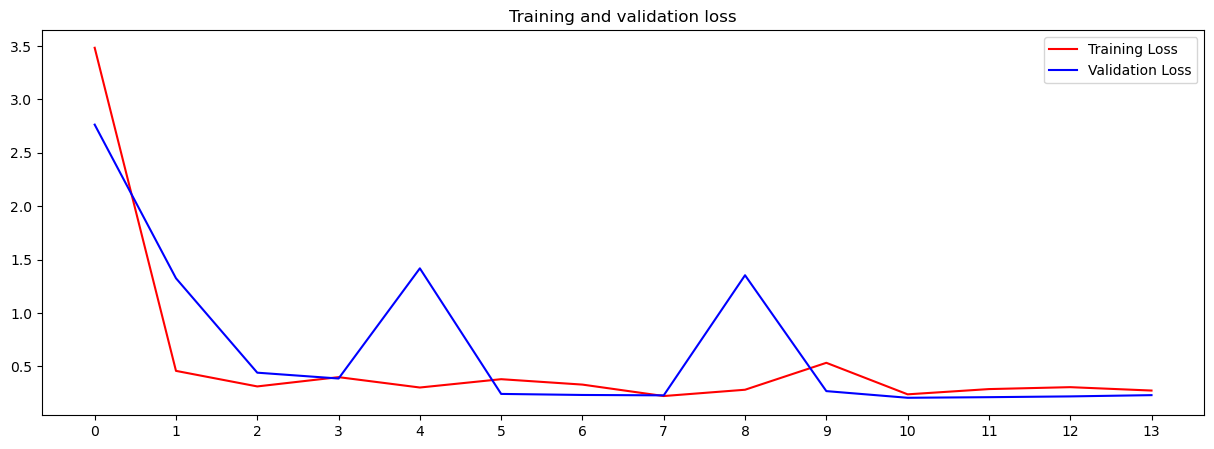

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.figure(figsize=(15,5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xticks(epochs)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.figure(figsize=(15,5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting

Loading the best model during training, considering the lowest validation loss.

In [18]:
model_best = load_model(checkpoint_path)

In [19]:
test_images = from_csv_nparray(test_set, True)
test_images = np.expand_dims(test_images, axis=-1)
predictions = model_best.predict(test_images)
predictions

875/875 [==============================] - 9s 10ms/step


array([[0.        , 0.        , 0.99999994, ..., 0.        , 0.        ,
        0.        ],
       [0.99999994, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.99999994],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.99999994],
       [0.        , 0.        , 0.99999994, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

[np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) is used below to obtain the indices of the maximum values along the rows of the predictions. In this case, th indices corresponds to the classes or digits.

In [20]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

Now, let's visualize our model's predictions. Into a grid of subplots, we generate the first 50 images along with their corresponding predicted classes.

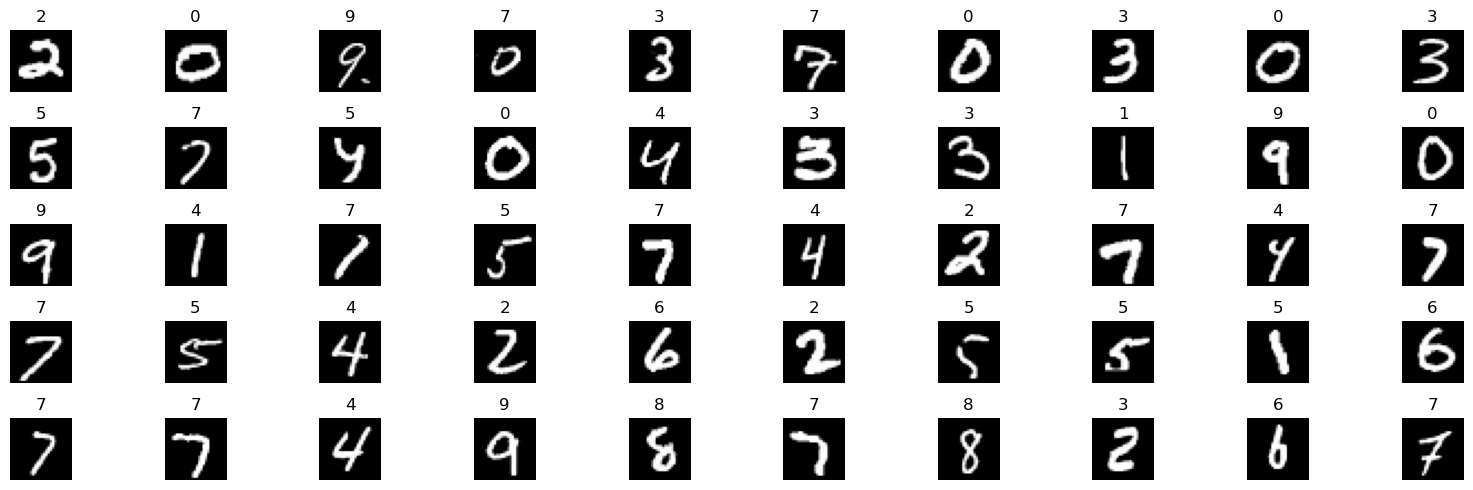

In [21]:
fig, axes = plt.subplots(5, 10, figsize=(16, 5))
axes = axes.flatten()

for i in range(50):
    img = test_images[i]
    img = array_to_img(img)
    ax = axes[i]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{predictions[i]}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Converting the predictions into a DataFrame. Saving the DataFrame to csv file.

In [22]:
submission = pd.DataFrame(data={'ImageId': np.arange(1, len(predictions) + 1),'Label': predictions})
submission.to_csv('./submissions/submission.csv', index=False)